# Understanding Data Flow in Deep Learning: CPU, GPU, RAM, VRAM, Cache, and Disk Storage

## Memory Hierarchy Overview
At the top of the pyramid, we have small but extremely fast memory, and as we go down the pyramid,
memory becomes slower but larger in capacity. Below is an illustration of the typical memory hierarchy
in modern computers:

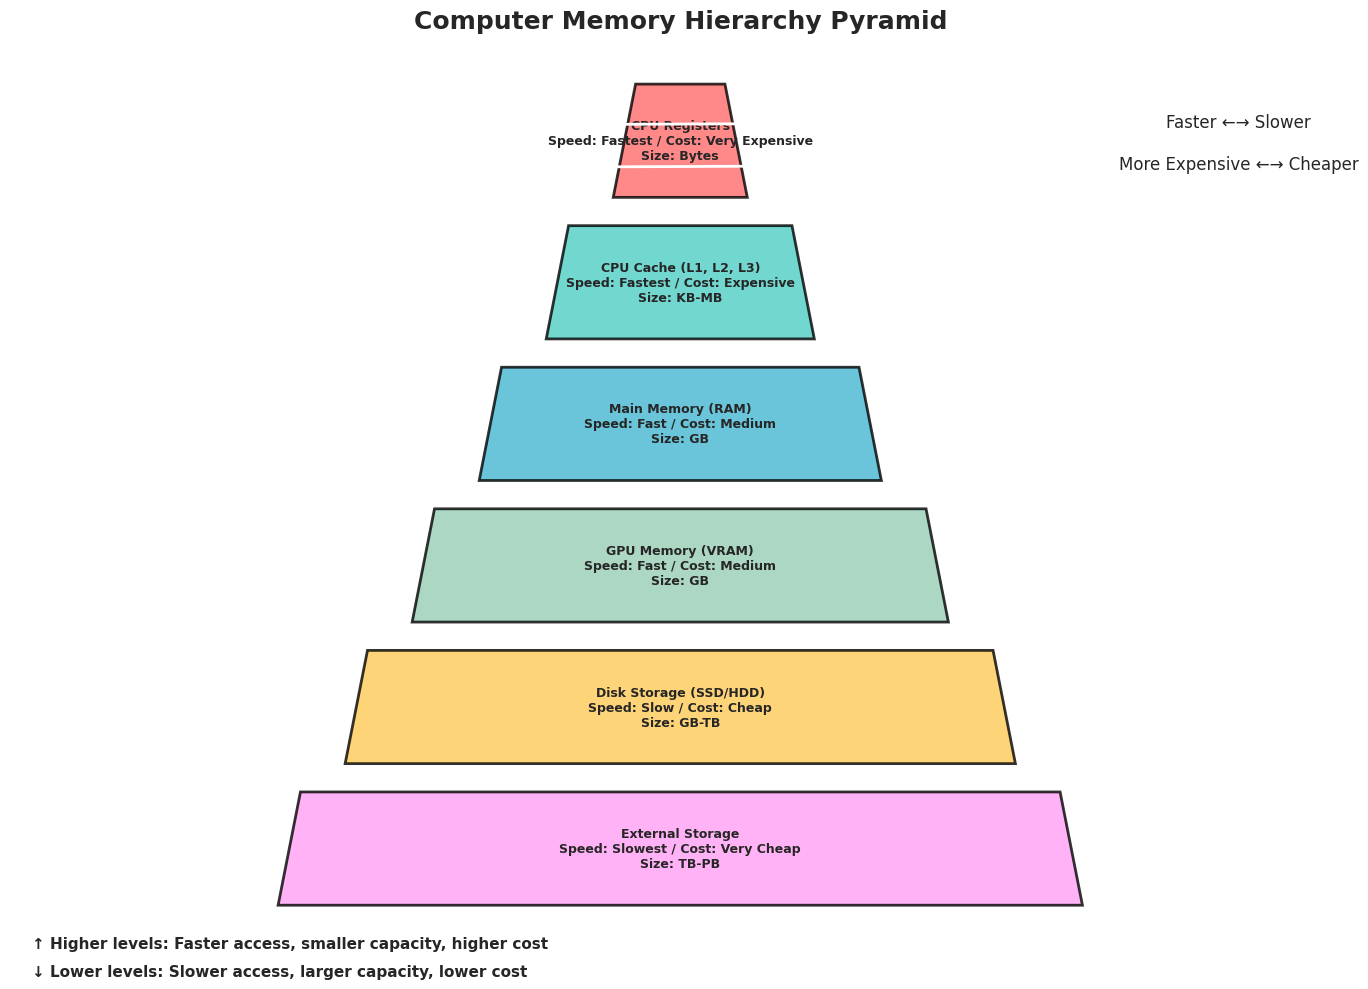

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def create_memory_pyramid():
    fig, ax = plt.subplots(figsize=(14, 10))

    # Memory hierarchy data
    levels = [
        {"name": "CPU Registers", "speed": "Fastest", "cost": "Very Expensive", "size": "Bytes", "color": "#FF6B6B"},
        {"name": "CPU Cache (L1, L2, L3)", "speed": "Fastest", "cost": "Expensive", "size": "KB-MB", "color": "#4ECDC4"},
        {"name": "Main Memory (RAM)", "speed": "Fast", "cost": "Medium", "size": "GB", "color": "#45B7D1"},
        {"name": "GPU Memory (VRAM)", "speed": "Fast", "cost": "Medium", "size": "GB", "color": "#96CEB4"},
        {"name": "Disk Storage (SSD/HDD)", "speed": "Slow", "cost": "Cheap", "size": "GB-TB", "color": "#FECA57"},
        {"name": "External Storage", "speed": "Slowest", "cost": "Very Cheap", "size": "TB-PB", "color": "#FF9FF3"}
    ]

    # Create pyramid coordinates
    y_positions = np.array([5, 4, 3, 2, 1, 0])
    widths = np.array([0.3, 0.6, 0.9, 1.2, 1.5, 1.8]) * 2

    for i, (level, y, width) in enumerate(zip(levels, y_positions, widths)):
        # Create trapezoid for pyramid effect
        x_center = 3.0
        x_left = x_center - width/2
        x_right = x_center + width/2

        # Draw trapezoid
        vertices = np.array([[x_left, y], [x_right, y],
                           [x_right - 0.1, y + 0.8], [x_left + 0.1, y + 0.8]])
        poly = plt.Polygon(vertices, closed=True,
                          facecolor=level["color"], alpha=0.8,
                          edgecolor='black', linewidth=2)
        ax.add_patch(poly)

        # Add text
        text = f"{level['name']}\nSpeed: {level['speed']} / Cost: {level['cost']}\nSize: {level['size']}"
        ax.text(x_center, y + 0.4, text, ha='center', va='center',
               fontsize=9, fontweight='bold', linespacing=1.2)

    # Add arrows showing speed/cost relationship
    ax.annotate('Faster ←→ Slower', xy=(0.5, 5.5), xytext=(5.5, 5.5),
               arrowprops=dict(arrowstyle='<->', lw=2), fontsize=12, ha='center')
    ax.annotate('More Expensive ←→ Cheaper', xy=(0.5, 5.2), xytext=(5.5, 5.2),
               arrowprops=dict(arrowstyle='<->', lw=2), fontsize=12, ha='center')

    # Customize plot
    ax.set_xlim(0, 6)
    ax.set_ylim(-0.5, 6)
    ax.set_title('Computer Memory Hierarchy Pyramid', fontsize=18, fontweight='bold', pad=20)

    # Remove axes
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Add legend
    ax.text(0.1, -0.3, "↑ Higher levels: Faster access, smaller capacity, higher cost",
           fontsize=11, fontweight='bold')
    ax.text(0.1, -0.5, "↓ Lower levels: Slower access, larger capacity, lower cost",
           fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

create_memory_pyramid()

## GPU Memory (VRAM)
Graphics Processing Units (GPUs) are often used to accelerate deep learning computations, and they have their dedicated memory, called Video RAM (VRAM). VRAM is faster than RAM because it is located closer to the GPU, which can be accessed it without going through the CPU.
**Real-world Example:** When training a deep learning model on a GPU, the model and the data mustbe loaded into the GPU’s VRAM. If the dataset is too large for the VRAM, the model must offload somedata back to RAM or disk, which slows down training.

In [3]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = torch.randn(10000, 100).to(device) # Load data into GPU VRAM
model = torch.nn.Linear(100, 10).to(device) # Load model into GPU VRAM

output = model(data) # Process data using the model on the GPU
print(output)

tensor([[ 0.3397, -0.1374, -0.0264,  ..., -0.2312, -0.0095, -1.7101],
        [ 0.0565,  0.4506, -0.6229,  ...,  0.0630,  0.8790, -0.0035],
        [-0.3179, -0.4185,  0.2446,  ..., -0.8805, -0.4818,  0.0926],
        ...,
        [-0.5373, -0.1173,  0.6941,  ..., -0.6429, -0.0564, -0.0389],
        [ 0.4140, -0.2753, -0.4857,  ...,  0.7327, -0.2623,  0.1043],
        [ 0.5111,  0.3668, -1.1642,  ..., -0.0311, -1.3652, -0.7599]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


| Diff | Data Loading to VRAM | Model Loading to VRAM |
| --- | --- |
| What moves | Actual input values (10000×100 tensor = ~8MB) | Model parameters (weights, biases), gradients, optimizer states |
| Memory usage | Temporary - exists only during processing     | Persistent - stays in VRAM during entire training |
| Transfer pattern | Frequent (each batch), can be streamed    | One-time (at start), but parameters update during training |
| Lifetime | Short-lived (processed then potentially discarded) | Long-lived (entire training session) |

In [2]:
import torch
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model parameters (persistent in VRAM)
model = nn.Sequential(
    nn.Linear(100, 50),   # ~100×50 = 5,000 parameters
    nn.ReLU(),
    nn.Linear(50, 10)     # ~50×10 = 500 parameters
).to(device)

print("Model parameters moved to VRAM:")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape} → {param.device}")

# Data (temporary in VRAM)
data = torch.randn(1000, 100).to(device)  # 1000 samples × 100 features
print(f"\nData tensor: {data.shape} on {data.device}")

# Check memory usage
if torch.cuda.is_available():
    print(f"\nGPU Memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

Model parameters moved to VRAM:
0.weight: torch.Size([50, 100]) → cuda:0
0.bias: torch.Size([50]) → cuda:0
2.weight: torch.Size([10, 50]) → cuda:0
2.bias: torch.Size([10]) → cuda:0

Data tensor: torch.Size([1000, 100]) on cuda:0

GPU Memory allocated: 0.40 MB


### Differences between Main Memory (RAM) and GPU Memory (VRAM)
RAM communicates directly with the central processing unit (CPU), storing program data and temporary information needed for various computational tasks. In contrast, VRAMis specifically designed for the graphics processing unit (GPU) to handle image and video rendering tasks. Due to the high parallelism and large data requirements of GPUs, VRAM is designed with higher bandwidth and lower latency to quickly access and process graphical data.

The **complexity of data transfer** between the two is also an important distinction. If data needs to
be transferred from RAM to VRAM, it must typically pass through the CPU. The CPU coordinates the
process of fetching data from the main memory and transmitting it to the GPU’s VRAM over the PCIe
bus. While this process is relatively efficient, it still introduces some latency due to the transfer.

There is also a difference in **physical location and bandwidth**. RAM is typically located on the CPU
side and connects to the CPU through memory buses like DDR. VRAM, on the other hand, surrounds
the GPU. Because of this close integration, VRAM typically has higher bandwidth than RAM to meet
the demands of large data transfers during GPU-intensive tasks. For example, GDDR (Graphics DDR)
memory often has significantly higher bandwidth than standard DDR memory. This high bandwidth
allows the GPU to handle complex graphical rendering and video processing without becoming
bottlenecked by slow data transfer rates.

### CPU Cache: Faster Memory Access
The CPU has several levels of cache (L1, L2, and sometimes L3), which are much smaller and faster
than RAM. The CPU cache is used to temporarily store data that is frequently accessed or recently
used, speeding up operations by reducing the need to constantly access slower RAM.
When your deep learning framework, such as PyTorch or TensorFlow, loads small batches of data,
the CPU might place part of that data in its cache to accelerate further computation.

Disk --> RAM --> CPU Cache

This way, the CPU only has to load data from the RAM once, and subsequent operations are done
using the cache, which is much faster.

### L3 Cache Allocation Strategies and Their Impact
L3 cache differs from L1 and L2 caches in that it is often shared among multiple CPU cores, making it
a critical resource in modern multi-core processors. The way the L3 cache is allocated across these
cores can have a significant effect on both CPU and GPU-accelerated tasks.
Two main strategies for L3 cache allocation are:
*
* **Static Allocation:** This method assigns a fixed portion of the L3 cache to each core or process. While predictable, static allocation can lead to inefficient cache usage if some cores are underutilized, leaving portions of the cache unused.
* **Dynamic Allocation:** In this strategy, the L3 cache is distributed based on real-time needs. Cores or processes that require more cache can dynamically receive a larger share, optimizing for overall system performance by reducing cache misses.

####  Impact on Deep Learning and GPGPU Workloads
In deep learning frameworks like PyTorch or TensorFlow, dynamic L3 cache allocation can be particularly
beneficial when pre-processing data or managing multiple threads. For example, when CPU
threads handle data preprocessing before transferring it to the GPU, dynamic cache allocation allows
more cache space to be allocated to the most active threads, reducing memory latency and speeding
up data transfers.
For GPGPU tasks, managing cache contention between multiple cores becomes important. If a
large dataset is being transferred to the GPU, dynamic allocation can reduce bottlenecks by optimizing
cache usage across the CPU cores handling different parts of the data.
On the other hand, static cache allocation might be preferable for real-time inference tasks, where
maintaining predictable latency is crucial. By assigning a fixed portion of the cache to each core, the
system can ensure consistent performance, which is critical in applications like autonomous driving
or real-time video analysis.
Choosing between static and dynamic L3 cache allocation depends on the workload. Dynamic
allocation often improves performance in data-intensive, parallel tasks, especially when working with
deep learning and GPGPU workloads. However, static allocation may be more suitable for tasks requiring
predictable performance, such as real-time inference. By optimizing L3 cache usage, overall
system efficiency can be improved, leading to faster data processing and reduced latency in both CPU
and GPU operations.

## Transferring Data to the GPU (VRAM and GPU Cache)
Once the data is in RAM and possibly cached by the CPU, the next step is to send it to the GPU for computation. The GPU has its memory, called **VRAM (Video Random Access Memory)**, which is optimized for parallel tasks such as deep learning matrix computations. In addition to VRAM, the GPU also has its **cache hierarchy (L1, L2 cache)**. When processing large datasets, frequently accessed data may be stored in the GPU’s cache, much like in the CPU.

``` image_tensor = torch.tensor(image).to('cuda') ```

Here, the image tensor is moved from the CPU to the GPU’s VRAM. Once in the VRAM, the data
can be cached in the GPU’s L1 or L2 cache, allowing the GPU to perform computations much faster by
minimizing access to VRAM.


## Data Flow during Training
During training, batches of data are repeatedly loaded from the disk into RAM and then moved to VRAM for GPU computation. The GPU uses both its VRAM and cache to efficiently process the data, perform computations, and update model parameters. After each computation, results (such as loss values or updated model weights) may be sent back to the CPU for logging or further analysis.
Here is a typical data flow during training:

``` Disk to RAM ---> RAM to CPU Cache ---> CPU Cache to VRAM ---> VRAM to GPU Cache ```

This flow continues in each batch of data. If data is used repeatedly (e.g., in multiple epochs), it will likely remain in the caches, further speeding up subsequent operations.

## Example Workflow: Training a Simple Neural Network
Let’s walk through an example in PyTorch to see how the data moves through different memory locations.

In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Data Loading Phase : Loading the dataset into RAM
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# Model and Optimizer Setup ( Model will be transferred to GPU )
model = torch.nn.Linear(28*28, 10).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Training Loop
for epoch in range(5):
    for batch in train_loader:
        inputs, labels = batch

        # Data from RAM to CPU Cache
        inputs, labels = inputs.view(inputs.size(0), -1), labels

        # Data from CPU to GPU (VRAM)
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        # Forwardpass and backpropagation
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()

        # Optimizer Step Done on GPU
        optimizer.step()

In this example:
1. The MNIST dataset is loaded from the disk to RAM.
2. Small batches of data are likely cached in the CPU cache during training to speed up operations.
3. Data is moved from the CPU (RAM or cache) to the GPU’s VRAM for processing.
4. The GPU caches frequently accessed data to avoid unnecessary reads from VRAM.
5. After processing, the results are sent back to the CPU for logging and analysis.

This is an excellent example showing the complete data pipeline in deep learning. Let me break down each step in detail:
1. **Data Loading Phase**
    * Disk → RAM: MNIST dataset (60,000 images) is downloaded and loaded into system RAM
    * **Transforms:** Images are converted from PIL format to PyTorch tensors (values 0-1)
    * **DataLoader:** Creates an iterator that will serve batches of 64 images
    * **Shuffling:** Data is shuffled every epoch to avoid learning order patterns
2. **Model Setup**
    * **Model Creation:** A simple linear classifier (784 input features → 10 output classes)
    * **GPU Transfer**: Model parameters (weights/bias) are moved to GPU VRAM
    * **Optimizer Setup:** SGD optimizer tracks model parameters for gradient updates
3. **Training Loop**
    * **Step A:** Batch Retrieval
        * **RAM → CPU Cache:** A batch of 64 images is fetched from RAM to CPU cache
        * **Automatic Caching:** CPU caches frequently accessed data for faster subsequent reads
    * **Step B:** Data Preparation
        * **Reshaping:** Images (64, 1, 28, 28) are flattened to (64, 784) for the linear layer
        * **CPU Processing:** This reshaping happens in CPU memory
    * **Step C:** GPU Transfer
        * **CPU → GPU:** Data is copied from CPU RAM to GPU VRAM via PCIe bus
        * **Async Operation:** This transfer happens asynchronously (GPU works while data transfers)
    * **Step D:** Forward Pass
        * **GPU Computation:** Matrix multiplication happens entirely in GPU
        * **GPU Cache:** Frequently accessed weights are cached in GPU's L1/L2 cache
        * **VRAM Access:** Model weights are read from VRAM, results stored in VRAM
    * **Step E:** Loss Calculation
        * **GPU Math:** Loss calculation happens on GPU
        * **No CPU Involvement:** Entire computation stays on GPU
    * **Step F:** Backward Pass
        * **Autograd:** GPU computes gradients for all parameters
        * **Gradient Storage:** Gradients are stored in GPU VRAM alongside parameters
    * **Step G:** Optimization
        * **Weight Update:** SGD updates model weights on GPU using gradients
        * **In-Place Operations:** Weight modifications happen directly in GPU VRAM

![](./public/data-pipeline-DL-flowchart.png)